In [21]:
import cluster_peptides as cp
import time

import argparse
import numpy as np
import subprocess
import pickle
import scipy.cluster.hierarchy as sch
import time
from Bio.Align import substitution_matrices
from joblib import Parallel, delayed
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from random import choice
import string
import os

incsv = '/projects/0/einf2380/data/external/unprocessed/mhcflurry.allele_sequences.csv'

genes = {}
with open(incsv, 'r') as infile:
    next(infile)
    for line in infile:
        row = line.replace('\n','').split(',')
        if row[0].startswith('HLA-'):
            try:
                genes[row[0][4]][row[0]] = row[1]
            except KeyError:
                genes[row[0][4]] = {row[0] : row[1]}
        
genes.keys()

dict_keys(['A', 'B', 'C', 'E', 'F', 'G'])

In [27]:
def get_score_matrix(peptides, n_jobs, matrix):
    #peptides = sorted(list(set(peptides)))

    batches = cp.split_in_indexed_batches(peptides, n_jobs)

    arrays = Parallel(n_jobs=n_jobs, verbose=1)(delayed(cp.get_scores)(matrix, batch, peptides) for batch in batches)
    arrays = [sorted(a, key=lambda x:x[0]) for a in arrays]

    score_array = []
    for x in arrays:
        x = [y[1] for y in x]
        score_array.extend(x)

    return score_array

def cluster_peptides(sequences, n_clusters, frag_len = 37,
                     matrix='PAM250', n_jobs=1, make_graphs=False,
                     labels=None, score_array= None, truncate_p=12):
    # matrix='PAM250'
    # n_jobs = 1
    # n_clusters = 5
    # frag_len = 37
    # make_graphs=True


    t1 = time.time()

    if labels == None:
        sequences = sorted(list(set(sequences)))
    
    if score_array:
        pass
    else:
        score_array = get_score_matrix(sequences, n_jobs, matrix)

    t2 = time.time()

    #Convert the distances in a score array
    dist_array = []
    top = max(score_array)
    for x in score_array:
        y = top + 1 - x
        dist_array.append(y)
    array = np.asarray(dist_array)

    t3 = time.time()
    #Calculate linkage between peptides (i.e. the dendrogram)
    result = sch.linkage(array, method='average')

    t4 = time.time()

    #Plot dendrogram
    if make_graphs:
        plt.figure(figsize=(60, 20))
        plt.title('Sequences Hierarchical Clusterization')
        plt.xlabel('Sequences')
        plt.ylabel('Distance')
        sch.dendrogram(
            Z=result,
            leaf_rotation=90.,  # rotates the x axis labels
            leaf_font_size=8.,  # font size for the x axis labels
            show_contracted=True,
            labels = labels,
            truncate_mode='level', p=truncate_p,
        )
        plt.axhline(n_clusters, color='b')
        plt.show()
        #plt.savefig(f"../../reports/figures/{filename}_dendogram_{matrix}.png", dpi=200)
        plt.clf()

    if make_graphs:
        last = result[:,2]
        Y = last[::-1]
        idxs = np.arange(1, len(last)+1)
        plt.plot(idxs,Y)
        plt.xlabel("Distance index")
        plt.ylabel("Distance")
        plt.title(f"Ranked distances between dendogram clusters for the {matrix} matrice")
        plt.show()
        #plt.savefig(f"../../reports/figures/elbow_{matrix}.png")
        plt.clf()
        #print(f"Elbow figure saved in reports/figures/{filename}_elbow_{matrix}.png")

    t5 = time.time()
    #Produce clusters using the given threshold
    fc = sch.fcluster(result, n_clusters, criterion='distance') # the number inside specifies the cutoff distance for dividing clusers
    if labels:
        ordered_clusters = sorted(zip(fc, sequences, labels))
    else: 
        ordered_clusters = sorted(zip(fc, sequences))
    clst_dct = {}
    # mtf_lst = []
    for i in set(fc):
        clst_dct['clst_%s' % (i-1)] = []
        # mtf_lst.append([])


    for clst in clst_dct:
        lenght = len(clst)
        number = clst[5:lenght]
        for i in ordered_clusters:
            if str((i[0]-1)) == (number):
                if labels:
                    clst_dct[clst].append((i[1], i[2]))
                else:
                    clst_dct[clst].append(i[1])
        # mtf_lst[(int(number))] = [[] for j in range(frag_len)]
        # for i in range(frag_len):
        #     for frag in clst_dct[clst]:
        #         if len(frag) == frag_len:
        #             mtf_lst[(int(number))][i].append(frag[i])
        #     mtf_lst[(int(number))][i] = list(set(mtf_lst[(int(number))][i]))

    t6 = time.time()

    print('Calculate distances:', t2-t1)
    print('Distances array:', t3-t2)
    print('Linkage:', t4-t3)
    print('Plot:', t5-t4)
    print('Clusters:', t6-t5)
    
    return clst_dct



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.1s finished


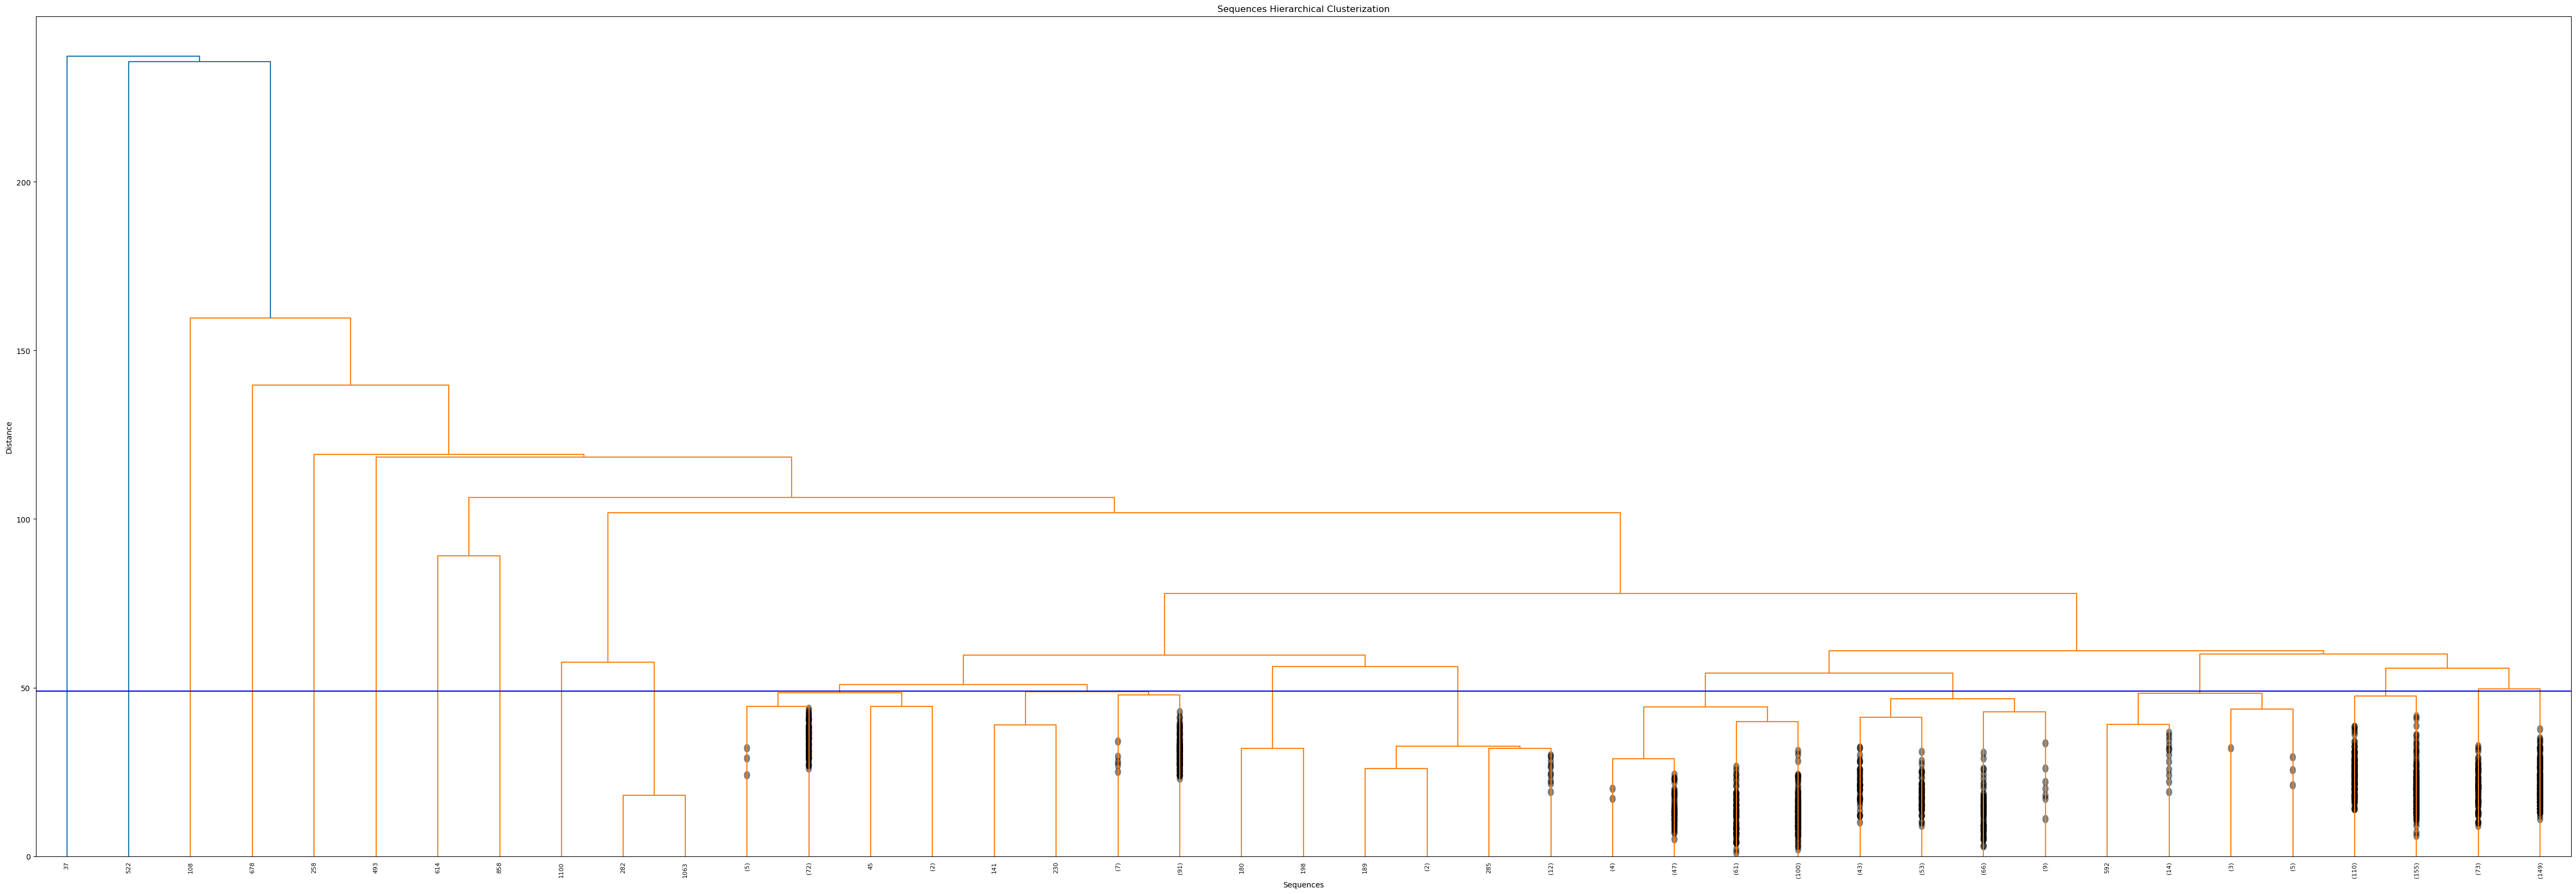

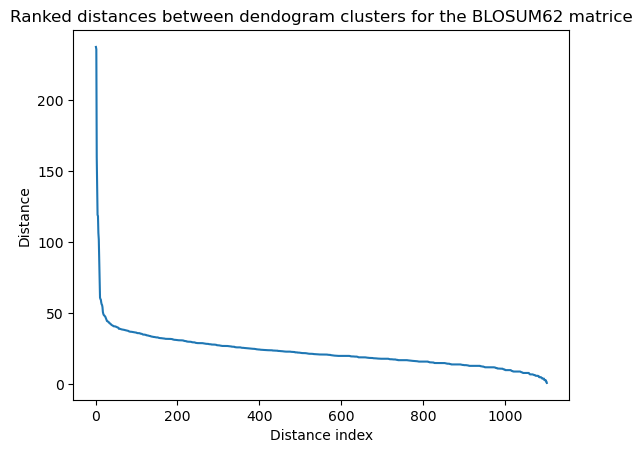

Calculate distances: 37.2186553478241
Distances array: 0.24505877494812012
Linkage: 0.01937246322631836
Plot: 3.748089075088501
Clusters: 0.04937553405761719


<Figure size 640x480 with 0 Axes>

In [23]:
labels = list(genes['C'].keys())
sequences =list(set( list(genes['C'].values())))

clusters = cluster_peptides(
    sequences=sequences,
    matrix='BLOSUM62',
    n_jobs = 1,
    n_clusters = 49,
    frag_len = 37,
    make_graphs=True,
    labels = None,
    truncate_p = 12
)



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.0min finished


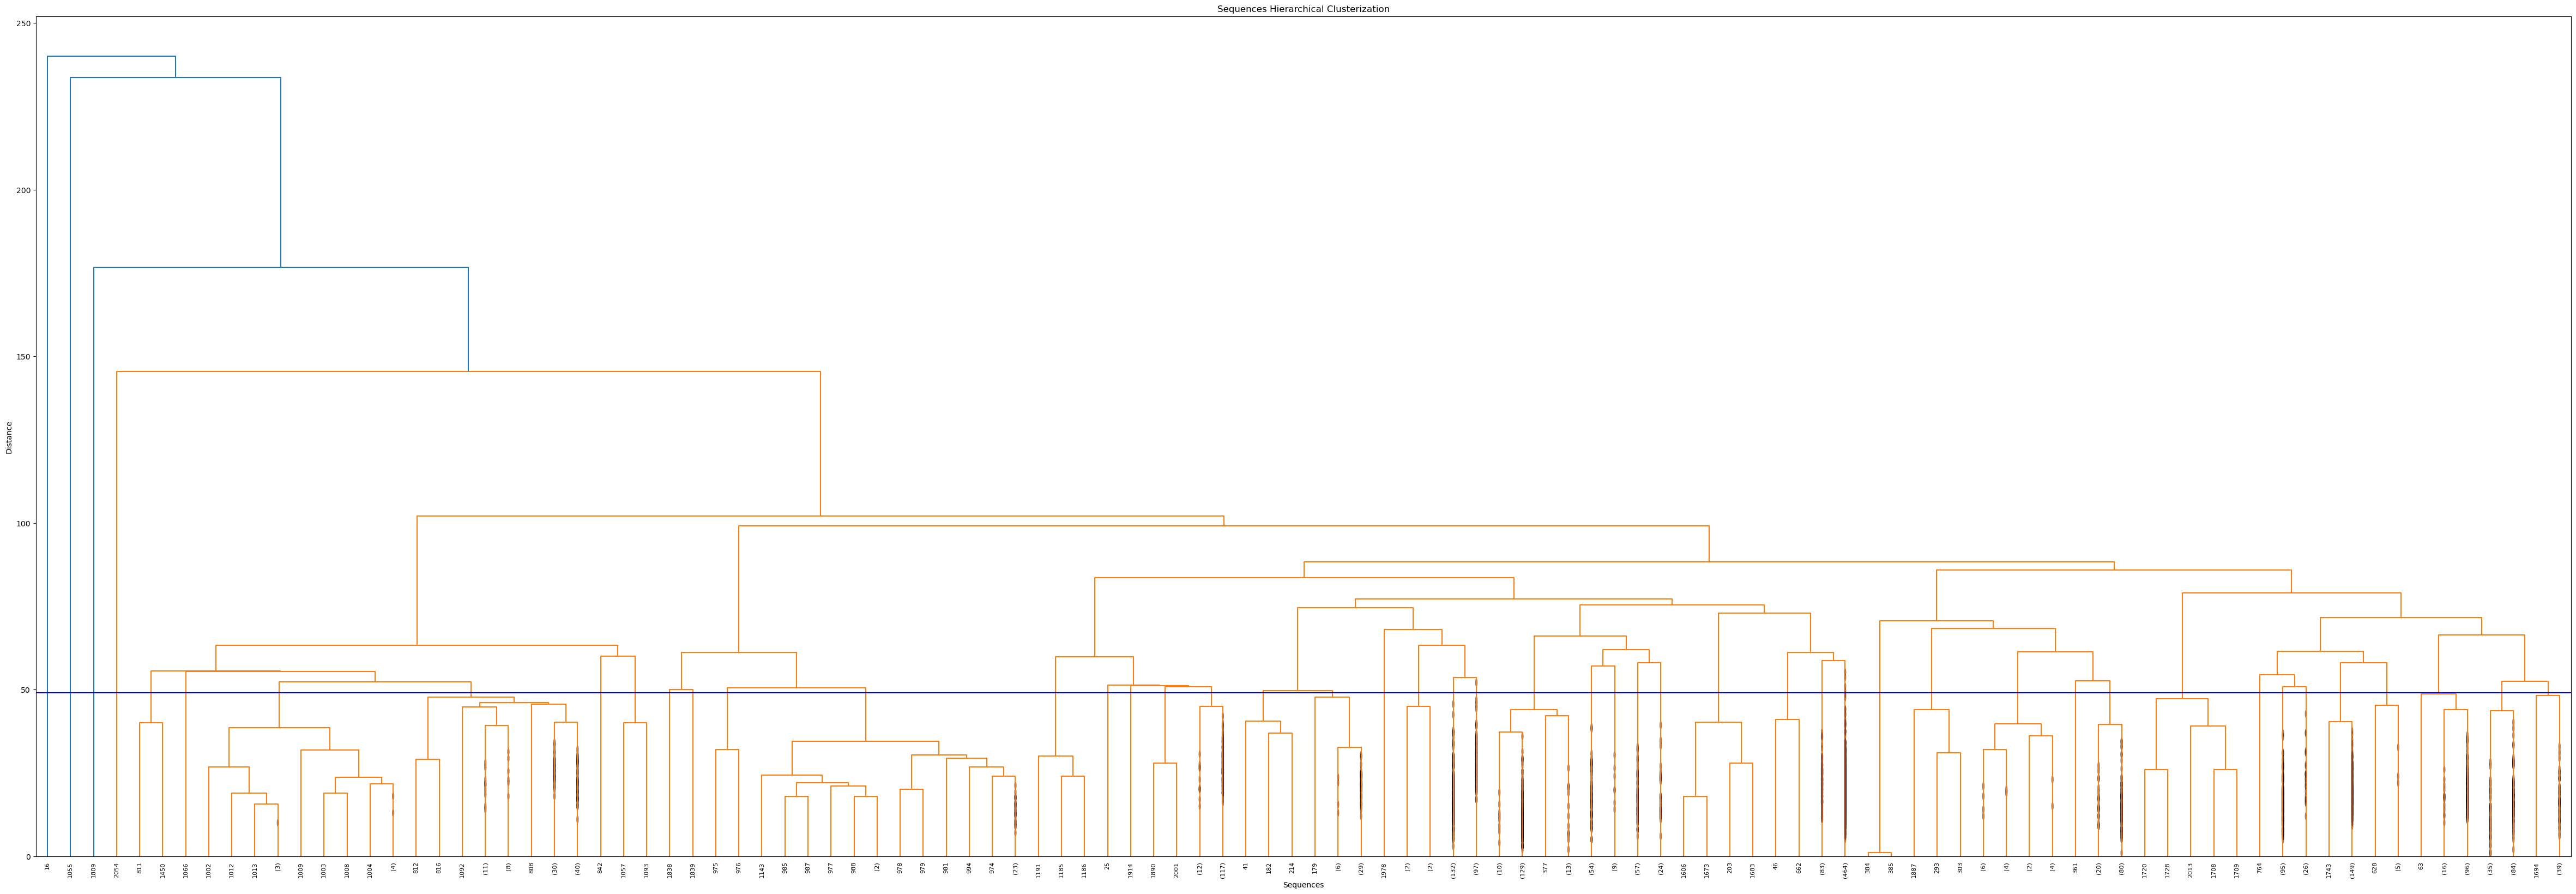

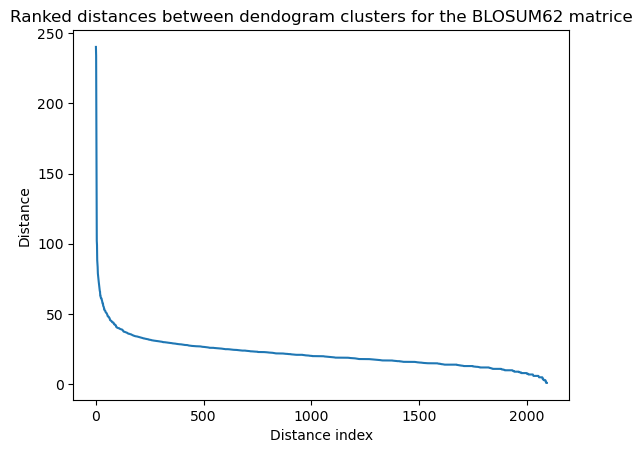

Calculate distances: 120.19203662872314
Distances array: 0.8637139797210693
Linkage: 0.08404064178466797
Plot: 6.078493118286133
Clusters: 0.24672770500183105


<Figure size 640x480 with 0 Axes>

In [28]:
labels = list(genes['B'].keys())
sequences =list(set( list(genes['B'].values())))

clusters = cluster_peptides(
    sequences=sequences,
    matrix='BLOSUM62',
    n_jobs = 1,
    n_clusters = 49,
    frag_len = 37,
    make_graphs=True,
    labels = None,
    truncate_p = 12
)

In [29]:
labels = list(genes['A'].keys())
sequences =list(set( list(genes['A'].values())))

clusters = cluster_peptides(
    sequences=sequences,
    matrix='BLOSUM62',
    n_jobs = 1,
    n_clusters = 49,
    frag_len = 37,
    make_graphs=True,
    labels = None,
    truncate_p = 12
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [24]:
#inv_genes = {g: {v: k for k, v in genes[g].items()} for x in genes}
inv_genes = {}
for g in genes:
    inv_genes[g] = {}
    for k, v in genes[g].items():
        try:
            inv_genes[g][v].append(k)
        except KeyError:
            inv_genes[g][v] = [k]
            
names_clusters = {c : {s : inv_genes['C'][s] for s in clusters[c]} for c in clusters}
print([(n, len(names_clusters[n])) for n in names_clusters])

[('clst_0', 1), ('clst_1', 1), ('clst_2', 2), ('clst_3', 1), ('clst_4', 80), ('clst_5', 100), ('clst_6', 2), ('clst_7', 16), ('clst_8', 212), ('clst_9', 171), ('clst_10', 23), ('clst_11', 265), ('clst_12', 73), ('clst_13', 149), ('clst_14', 1), ('clst_15', 1), ('clst_16', 1), ('clst_17', 1), ('clst_18', 1), ('clst_19', 1)]


In [25]:
#print(names_clusters['clst_5'].values())
print([(x, len(y)) for x,y in names_clusters['clst_5'].items()])
names_clusters['clst_5']['YDSGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYA']

[('CDSGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('DDSGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('FDSGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYA', 1), ('YDAGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYA', 1), ('YDAGYRENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('YDSEYRENYRQADVSNLYGLRYDDSYTLAALAYTWYA', 1), ('YDSGYLENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('YDSGYPENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('YDSGYQENYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVNKLYGLRYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVNKLYGLWYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGIRYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGLNYDDSYTLAALAYTWYA', 1), ('YDSGYREKYRQADVSNLYGLNYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGLRCDDSYTLAALAYTWYA', 1), ('YDSGYREKYRQADVSNLYGLRFDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGLRSDDSCTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGLRYDDSYTLAALAYTWYA', 3), ('YDSGYREKYRQADVSNLYGLRYDDSYTLAALAYTWYX', 1), ('YDSGYREKYRQADVSNLYGLSYDDSYTLAALAYTWYA', 2), ('YDSGYREKYRQADVSNLYGLWYDDSYTLAALAYTWYX', 1), ('YDSGYRENHRQADVSNLYGLRYDDSYTLAAL

['HLA-C*07:01',
 'HLA-C*07:06',
 'HLA-C*07:106',
 'HLA-C*07:112',
 'HLA-C*07:118',
 'HLA-C*07:119',
 'HLA-C*07:153',
 'HLA-C*07:16',
 'HLA-C*07:163',
 'HLA-C*07:166',
 'HLA-C*07:18',
 'HLA-C*07:205',
 'HLA-C*07:21',
 'HLA-C*07:24',
 'HLA-C*07:276',
 'HLA-C*07:300',
 'HLA-C*07:301',
 'HLA-C*07:337',
 'HLA-C*07:343',
 'HLA-C*07:35',
 'HLA-C*07:36',
 'HLA-C*07:371',
 'HLA-C*07:385',
 'HLA-C*07:386',
 'HLA-C*07:412',
 'HLA-C*07:419',
 'HLA-C*07:421',
 'HLA-C*07:422',
 'HLA-C*07:424',
 'HLA-C*07:450',
 'HLA-C*07:453',
 'HLA-C*07:458',
 'HLA-C*07:462',
 'HLA-C*07:488',
 'HLA-C*07:499',
 'HLA-C*07:508',
 'HLA-C*07:522',
 'HLA-C*07:527',
 'HLA-C*07:531',
 'HLA-C*07:540',
 'HLA-C*07:547',
 'HLA-C*07:550',
 'HLA-C*07:554',
 'HLA-C*07:555',
 'HLA-C*07:557',
 'HLA-C*07:57',
 'HLA-C*07:588',
 'HLA-C*07:59',
 'HLA-C*07:591',
 'HLA-C*07:607',
 'HLA-C*07:610',
 'HLA-C*07:613',
 'HLA-C*07:614',
 'HLA-C*07:615',
 'HLA-C*07:617',
 'HLA-C*07:618',
 'HLA-C*07:619',
 'HLA-C*07:620',
 'HLA-C*07:621',
 'HLA-C